In [8]:
import os
import numpy as np
import pandas as pd

import pymatgen as pg


In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

In [10]:

def local_min(df):

    df['dy'] = df['Edis'].diff()

    df['sign_dy'] = np.sign(df['dy'])
    df['sign_change'] = df['sign_dy'].diff()

    # Indices of local maxima: derivative goes from negative (-1) to positive (+1)
    local_min_indices = df.index[(df['sign_change'] > 0)]

    if len(local_min_indices) == 0:
        print('No local max found')
        new_df = pd.DataFrame(columns=['cell_length', 'Edis'])
        # put values 0 , 0 in the dataframe
        new_df.loc[0] = [0, 0]
        print(min(new_df['Edis']))
        return new_df
    local_mins = df.loc[local_min_indices, ['cell_length', 'Edis']].reset_index(drop=True)

    return local_mins

def local_max(df):
    df['dy'] = df['Edis'].diff()

    df['sign_dy'] = np.sign(df['dy'])
    df['sign_change'] = df['sign_dy'].diff()
    
    # Indices of local maxima: derivative goes from negative (-1) to positive (+1)
    local_min_indices = df.index[(df['sign_change'] < 0)]

    if len(local_min_indices) == 0:
        print('No local max found')
        new_df = pd.DataFrame(columns=['cell_length', 'Edis'])
        # put values 0 , 0 in the dataframe
        new_df.loc[0] = [0, 0]
        print(min(new_df['Edis']))
        return new_df

    local_max = df.loc[local_min_indices, ['cell_length', 'Edis']].reset_index(drop=True)
    return local_max

In [11]:
def finding_diff(df):
    abs_max = df['Edis'].iloc[-1]
    max_val = max(local_max(df)['Edis'])
    min_val = min(local_min(df)['Edis'])
    min_val_idx = local_min(df)[local_min(df)['Edis'] == min_val].index[0]
    min_length = local_min(df).loc[min_val_idx, 'cell_length']
    
    max_val_idx = local_max(df)[local_max(df)['Edis'] == max_val].index[0]
    
    # equation of line between two points (x1, y1) and (x2, y2)
    x1 = local_max(df).loc[max_val_idx, 'cell_length'] 
    x2 = df['cell_length'].iloc[-1]

    y1 = max_val
    y2 = abs_max
    # print(min_length)
    
    # Finding the maximum slope
    max_slope = float('-inf')
    best_x2 = x2
    best_y2 = y2
    
    # Get the dataframe points after x1
    points_after_x1 = df[df['cell_length'] > x1][['cell_length', 'Edis']]
    
    # Iterate through all points after x1
    for idx, row in points_after_x1.iterrows():
        temp_x2 = row['cell_length']
        temp_y2 = row['Edis']
        temp_slope = (y1 - temp_y2) / (x1 - temp_x2)
        
        if temp_slope > max_slope:
            max_slope = temp_slope
            best_x2 = temp_x2
            best_y2 = temp_y2
    
    x2 = best_x2
    y2 = best_y2
    slope = max_slope
    intercept = y2 - slope * x2

    if y2 < y1:
        slope = 0
        intercept = y1

    #value of y when x = min_length
    y_at_min_length = slope * min_length + intercept

    diff = abs(min_val - y_at_min_length)
    return diff


In [12]:
from pymatgen.core import Structure

In [13]:
#list all folders inside li_d3s
li_d3s = os.listdir("d3_calcs")

results = []

df = pd.DataFrame()
cnt=0
for items in li_d3s:
    cnt+=1
    #get the path of each folder
    path = os.path.join("d3_calcs", items)
    # print(items)
    
    #ignore .DS_Store
    if items == ".DS_Store":
        continue
    file = os.path.join(path, f'{items}.csv')
    struct_file = os.path.join(path, 'POSCAR')
    df = pd.read_csv(file)
    print(f"Reading {file}")
    # exract materials id from file name

    material_id = os.path.basename(file).split('.')[0].split('_')[1]
    print(f"Material ID: mp-{material_id}")
    struct = Structure.from_file(struct_file)
    sites = struct.num_sites
    
    # print(struct.composition['Li'])
    li_sites = struct.composition['Mn']
    counter_ion_sites = struct.composition[struct.composition.elements[1]]
    diff_energy = finding_diff(df)
    print(f'Composition {struct.composition}')
    print(f'diff per toal sites {diff_energy/sites}')
    print(f'diff per cation sites {diff_energy/li_sites}')
    print('-----------------------------------')

    result = {
        "Symbol": struct.composition.elements[0] if struct.composition.elements[0].symbol != 'Mn' else struct.composition.elements[1],
        "Structure": struct.composition,
        "Total Sites": sites,
        "Cation Sites": li_sites,
        "Counter Ion Sites": counter_ion_sites,
        "Diff Energy": diff_energy,
        "Diff per Total Sites": diff_energy/sites,
        "Diff per Cation Sites": diff_energy/li_sites,
        "Diff per Counter Ion Sites": diff_energy/counter_ion_sites,
        "Volume": struct.volume,
        "mid": material_id,
        "Composition": str(struct.composition)
    }

    results.append(result)
print(f'total structure analysed = {cnt}')
    

Reading d3_calcs/MnBe2_11270/MnBe2_11270.csv
Material ID: mp-11270
Composition Mn4 Be8
diff per toal sites 0.018855059438107384
diff per cation sites 0.05656517831432215
-----------------------------------
Reading d3_calcs/Mn7O12_754430/Mn7O12_754430.csv
Material ID: mp-754430
Composition Mn7 O12
diff per toal sites 0.0027562994916619107
diff per cation sites 0.0074813843345109005
-----------------------------------
Reading d3_calcs/MnPd_1902/MnPd_1902.csv
Material ID: mp-1902
Composition Mn1 Pd1
diff per toal sites 0.031301834794079664
diff per cation sites 0.06260366958815933
-----------------------------------
Reading d3_calcs/Mn15Si26_752/Mn15Si26_752.csv
Material ID: mp-752
Composition Mn30 Si52
diff per toal sites 0.005951617786860373
diff per cation sites 0.01626775528408502
-----------------------------------
Reading d3_calcs/MnO_1238899/MnO_1238899.csv
Material ID: mp-1238899
Composition Mn1 O1
diff per toal sites 0.00952920975657188
diff per cation sites 0.01905841951314376
-

### for individual elements

In [14]:
results_df = pd.DataFrame(results)
results_df.to_csv("analysis_results.csv", index=False)

print(f"Total structures analysed = {cnt}")
# print("Results saved to analysis_results.csv")

results_df['Diff per Total Sites'].max()*1000

Total structures analysed = 318


33.11551080891575

### Thougest part is to make the Feature functions data 


In [15]:
props = pd.read_csv('../mixed_comps/PubChemElements_all.csv')
polarisability = pd.read_csv('../elements_polarizability.csv')

props = props[['Symbol', 'AtomicMass','AtomicRadius','Electronegativity','IonizationEnergy','ElectronAffinity']]

In [16]:
all_props = []
cnt = 0
for items in li_d3s:
    # cnt+=1
    #get the path of each folder
    path = os.path.join("d3_calcs", items)
    # print(items)
    
    #ignore .DS_Store
    if items == ".DS_Store":
        continue
    file = os.path.join(path, f'{items}.csv')
    struct_file = os.path.join(path, 'POSCAR')


    struct = Structure.from_file(struct_file)
    sites = struct.num_sites

    vol_site = struct.volume/sites
    # print(density)

    # print(struct.composition.elements[1])

    elem = struct.composition.elements[0] if(struct.composition.elements[1].symbol == 'Mn')  else struct.composition.elements[1]

    print(elem)
    # print(elem.symbol == 'Ge')

    matched_row = props[props['Symbol'] == elem.symbol]
    elem_polarizability = polarisability[polarisability['Symbol'] == elem.symbol]

    space_group = struct.get_space_group_info()


    
    print(struct.composition.reduced_formula)
    # DiffPerLi = results_df[results_df['Symbol'] == elem.symbol]
    # matched_row.add('Polarizability', elem_polarizability['Polarizability'].values[0])
    matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
    matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
    matched_row['results_per_cation'] = results_df['Diff per Cation Sites'][cnt]*1000
    # matched_row['TotalSites'] = results_df['Total Sites'][cnt]
    matched_row['CationSites'] = results_df['Cation Sites'][cnt]/sites
    matched_row['CounterIonSites'] = results_df['Counter Ion Sites'][cnt]/sites
    matched_row['results_per_counter_ion'] = results_df['Diff per Counter Ion Sites'][cnt]
    # matched_row['Diff per Li Sites'] = DiffPerLi['Diff per Li Sites'].values[0]
    matched_row['res_per_volm_per_site'] = results_df['Diff per Total Sites'][cnt]/vol_site
    matched_row['Result']=  results_df['Diff per Total Sites'][cnt]/vol_site*1000
    matched_row['SpaceGroup'] = space_group[0]
    matched_row['SpaceGroupNumber'] = space_group[1]
    matched_row['Total Sites'] = sites
    matched_row['Volume'] = results_df['Volume'][cnt]
    matched_row['mid'] = results_df['mid'][cnt]
    matched_row["Reduced Formula"] = struct.composition.reduced_formula
    all_props.append(matched_row)

    cnt+=1

all_props_df = pd.concat(all_props, ignore_index=True)
    

Be
MnBe2
O
Mn7O12
Pd
MnPd
Si
Mn15Si26
O
MnO
Au
Mn9Au31
Ta
TaMn2
B
MnB
F
MnF3
Te
MnTe
P
MnP
H
Mn29H2
S
MnS2
Sb
Mn3Sb2
Pd
MnPd
O
MnO2
Au
MnAu3
As
MnAs
O
MnO2
Au
MnAu4
Er
ErMn2
O
MnO2
F
MnF2
O
Mn2O3
F
MnF4
Si
Mn4Si7
Ge
Mn5Ge3
Be
Mn3Be
C
Mn7C3
Ir
MnIr
Er
ErMn2
O
MnO4
F
MnF2
As
Mn3As2
F
MnF4
O
Mn2O3
S
MnS2
Pt
Mn3Pt
F
MnF3
Ga
Mn3Ga
As
Mn3As
Si
Mn5Si2
O
Mn2O3
Ga
Mn3Ga
F
MnF3
B
Mn3B4
Br
MnBr2
O
Mn3O4
O
Mn2O7
Be
MnBe12
P
MnP4
O
MnO2
O
MnO
Co
Mn3Co
Pt
MnPt3
S
Mn3S
O
MnO2
O
MnO
Se
MnSe
O
MnO2
Te
MnTe
S
MnS
Ga
Mn6Ga29
F
Mn2F5
As
Mn23As16
Ge
Mn3Ge
O
Mn2O3
P
Mn3P
Ni
MnNi
Al
MnAl6
P
Mn2P
O
MnO2
O
Mn2O3
O
Mn21O40
Co
MnCo


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_80687/810674269.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_80687/810674269.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_80687/810674269.py:41: SettingWithCop

Sb
MnSb
Sb
Mn3Sb
F
MnF4
P
MnP4
O
MnO2
O
Mn2O3
Sb
Mn3Sb
O
Mn15O32
Si
Mn3Si
F
MnF3
Te
MnTe
P
MnP4
B
MnB2
F
Mn3F10
Au
MnAu3
O
MnO3
F
MnF3
N
MnN
U
UMn2
Au
MnAu2
O
MnO
V
MnV3
Sb
Mn7Sb4
P
MnP4
Ge
MnGe2
Al
MnAl
P
MnP
Rh
MnRh
Ge
Mn5Ge2
F
MnF3
O
MnO2
Al
Mn3Al
F
MnF3
O
Mn3O4
F
MnF2
Ga
MnGa
S
Mn2S3
Se
MnSe
F
MnF3
O
Mn2O3
Zn
MnZn3
Nb
Mn2Nb
Ge
Mn5Ge2
Zr
ZrMn2
F
MnF3
N
Mn3N4
Pd
MnPd3
O
Mn5O8
O
Mn5O8
O
MnO2
Ir
Mn3Ir
Ru
MnRu3
Al
MnAl12
O
Mn2O3
O
Mn2O3
O
MnO2
Ti
TiMn2
O
Mn3O4
Pd
Mn7Pd9
N
Mn2N
F
MnF4
O
Mn5O7
As
MnAs
Ir
MnIr
Zr
ZrMn2
F
MnF3
Zr
ZrMn3
Be


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_80687/810674269.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_80687/810674269.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_80687/810674269.py:41: SettingWithCop

MnBe3
O
Mn3O4
Er
ErMn2
Al
Mn4Al11
Pd
Mn11Pd21
O
Mn2O3
N
MnN
Tm
Tm6Mn23
Ti
Ti5Mn3
F
Mn2F5
Co
Mn3Co
O
Mn3O4
Zn
MnZn13
Al
Mn5Al8
Er
Er6Mn23
O
Mn8O17
Sc
ScMn2
Te
MnTe
Ga
MnGa
O
MnO2
Se
MnSe2
V
MnV
Cl
MnCl2
Pt
MnPt
Ir
Mn3Ir
F
MnF3
Ir
MnIr3
N
Mn4N
O
MnO2
O
MnO2
Ti
Ti5Mn7
Ti
Ti21Mn25
Ge
MnGe
N
Mn2N
Ga
Mn3Ga
Hf
HfMn
O
MnO2
S
MnS2
Al
Mn4Al9
Zr
ZrMn2
F
Mn7F18
Ni
MnNi
As
Mn4As3


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_80687/810674269.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_80687/810674269.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_80687/810674269.py:41: SettingWithCop

Rh
Mn3Rh
B
MnB4
Sb
Mn14Sb13
Ni
MnNi3
Ga
Mn2Ga5
S
MnS
N
MnN
Si
Mn3Si
Tm
TmMn12
O
Mn9O13
P
MnP2
Br
MnBr2
O
MnO2
Au
MnAu
Br
MnBr2
Pd
Mn3Pd5
Ni
MnNi
Lu
Lu6Mn23
As
Mn2As
Pt
MnPt
F
MnF3
B
MnB
Ge
Mn3Ge
Al
Mn2Al3
Si
MnSi
Ge
Mn3Ge5
Te
Mn3Te
Yb
YbMn3
P
Mn2P
S
MnS2
Ge
Mn11Ge8
Yb
YbMn2
S
MnS2
F
Mn2F7
Hf
Hf2Mn
P
MnP4
Au
MnAu
Se
MnSe
Te
MnTe2
Zn
MnZn3
Ir
Mn3Ir
F
MnF4
Ga
MnGa4
Pd
MnPd2
Ga
Mn3Ga
F
MnF3
F
Mn3F8
N
Mn3N4
Hf
HfMn2
S
MnS2
As
Mn3As2
O
Mn15O32
Ge
Mn2Ge
Dy
DyMn12
O
MnO
Ga
MnGa6
O
MnO2
O
MnO2
O
Mn2O3
Sb
Mn2Sb
F
Mn2F7
P
MnP4
Te
Mn3Te
Si
Mn11Si19
Hf
HfMn


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_80687/810674269.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_80687/810674269.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_80687/810674269.py:41: SettingWithCop

Se
MnSe
Pd
MnPd3
O
Mn3O4
Dy
Dy6Mn23
Pd
MnPd3
O
Mn20O43
Ga
MnGa
Si
Mn5Si3
B
Mn2B
B
MnB4
Au
MnAu4
O
MnO2
Sb
Mn27Sb26
I
MnI2
C
Mn3C
Ir
MnIr
F
Mn2F7
Se
MnSe
Ge
Mn3Ge
Au
Mn2Au5
Hf
HfMn2
Sb
Mn3Sb
Al
Mn4Al19
O
Mn2O5
Si
Mn5Si2
N
Mn3N2
Zr
ZrMn2
Ho
HoMn12
Ni
MnNi
Te
MnTe
O
MnO2
Tm
TmMn12
C
Mn23C6
F
MnF3
Te
MnTe
N
MnN
O
Mn3O4
Pt
MnPt2
Au
MnAu3
Al
Mn3Al10
Sb
Mn5Sb4
O
MnO2
F
Mn2F7
U
UMn2
S
MnS
S
MnS
O
MnO
V
MnV
Zn
MnZn3
F
MnF4
Au
Mn2Au
F
MnF2
O
MnO2
F
Mn7F16
C
Mn5C2
O
Mn2O3
Ga
Mn8Ga5
Al
MnAl
O
Mn3O4
B
Mn4B
Zn
MnZn3
B
MnB4
Sb
MnSb
Si
Mn4Si7
Si
Mn5Si2
N
Mn3N2


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_80687/810674269.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_80687/810674269.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_80687/810674269.py:41: SettingWithCop

O
MnO2
O
Mn21O40


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_80687/810674269.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_80687/810674269.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_80687/810674269.py:41: SettingWithCop

In [17]:
all_props_df


,Symbol,AtomicMass,AtomicRadius,Electronegativity,IonizationEnergy,ElectronAffinity,Polarizability,results_per_total,results_per_cation,CationSites,CounterIonSites,results_per_counter_ion,res_per_volm_per_site,Result,SpaceGroup,SpaceGroupNumber,Total Sites,Volume,mid,Reduced Formula
0,Be,9.012183,153.0,1.57,9.323,NaN,37.74,18.855059,56.565178,0.333333,0.666667,0.028283,0.002199,2.198939,P6_3/mmc,194,12,102.895411,11270,MnBe2
1,O,15.999000,152.0,3.44,13.618,1.461,5.30,2.756299,7.481384,0.368421,0.631579,0.004364,0.000278,0.278008,Im-3,204,19,188.374663,754430,Mn7O12
2,Pd,106.420000,202.0,2.20,8.337,0.557,26.14,31.301835,62.603670,0.500000,0.500000,0.062604,0.002081,2.080972,Pm-3m,221,2,30.083861,1902,MnPd
3,Si,28.085000,210.0,1.90,8.152,1.385,37.30,5.951618,16.267755,0.365854,0.634146,0.009385,0.000496,0.496218,I-42d,122,82,983.505169,752,Mn15Si26
4,O,15.999000,152.0,3.44,13.618,1.461,5.30,9.529210,19.058420,0.500000,0.500000,0.019058,0.000665,0.664648,F-43m,216,2,28.674460,1238899,MnO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,Si,28.085000,210.0,1.90,8.152,1.385,37.30,6.978295,19.190310,0.363636,0.636364,0.010966,0.000608,0.607552,Pcc2,27,44,505.380748,568121,Mn4Si7
314,Si,28.085000,210.0,1.90,8.152,1.385,37.30,14.018310,19.625634,0.714286,0.285714,0.049064,0.001178,1.177848,P4_12_12,92,56,666.491146,1198479,Mn5Si2
315,N,14.007000,155.0,3.04,14.534,NaN,7.40,19.307453,32.179088,0.600000,0.400000,0.048269,0.001955,1.955200,I4/mmm,139,5,49.374635,12857,Mn3N2
316,O,15.999000,152.0,3.44,13.618,1.461,5.30,1.485112,4.455335,0.333333,0.666667,0.002228,0.000127,0.126786,Cm,8,48,562.250306,1350912,MnO2


In [18]:
all_props_df.to_csv('all_props_new.csv', index=False)

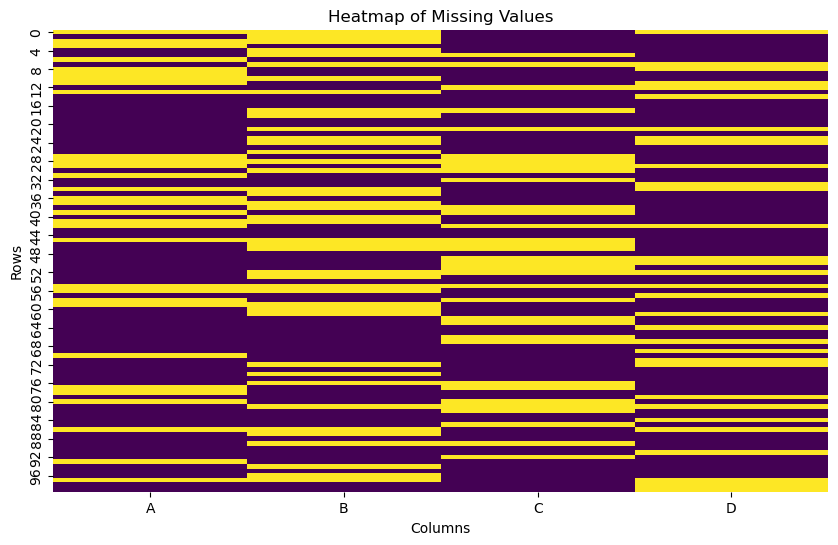

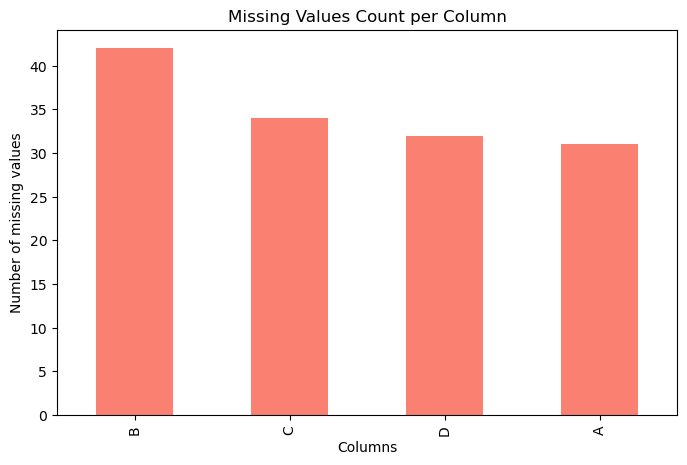

In [19]:
# show me some graphs to analyze NaN values

import matplotlib.pyplot as plt
import seaborn as sns

# Example DataFrame with NaN values (replace this with your actual DataFrame)
# For demonstration, we're creating a DataFrame with some random missing values.
np.random.seed(42)
data = {
    'A': np.random.choice([1, 2, np.nan], size=100),
    'B': np.random.choice([3, 4, np.nan], size=100),
    'C': np.random.choice([5, 6, np.nan], size=100),
    'D': np.random.choice([7, 8, np.nan], size=100)
}
df = pd.DataFrame(data)

# -------------------------------
# Plot 1: Heatmap of Missing Values
# -------------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Values")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

# -------------------------------
# Plot 2: Bar Chart of Missing Values per Column
# -------------------------------
missing_counts = df.isnull().sum().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
missing_counts.plot(kind="bar", color='salmon')
plt.ylabel("Number of missing values")
plt.xlabel("Columns")
plt.title("Missing Values Count per Column")
plt.show()

In [20]:
all_props_df.fillna(0, inplace=True)


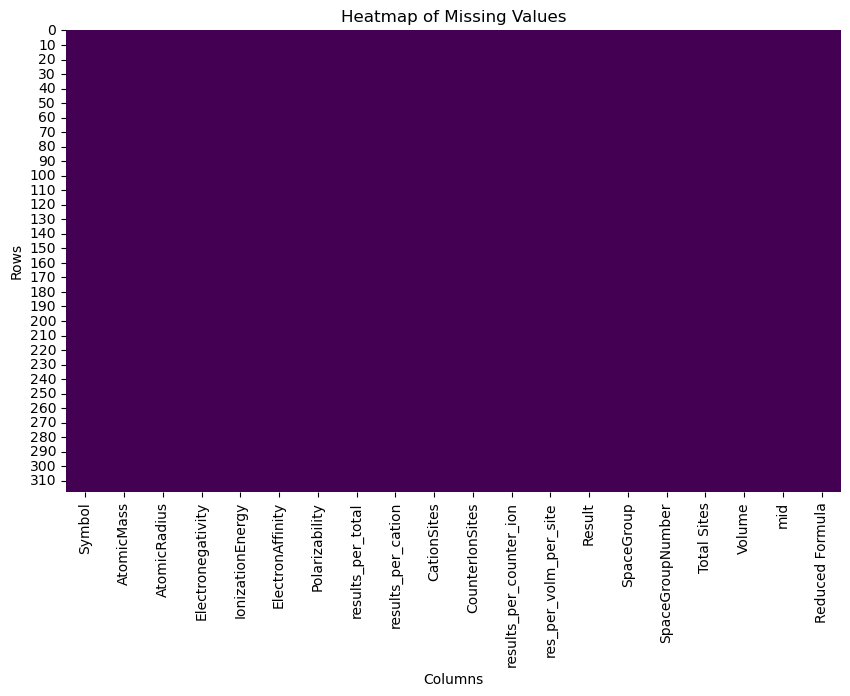

In [21]:
plt.figure(figsize=(10, 6))
sns.heatmap(all_props_df.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Values")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

In [22]:
# all_props_df.to_csv('all_props_new.csv', index=False)
all_props_df = pd.read_csv('all_props.csv')

all_props_df

FileNotFoundError: [Errno 2] No such file or directory: 'all_props.csv'